# Modelling the Performance of Photocatalytic Micelles

This project models the performance of photocatalytic micelles which are capable of catalysing the conversion of carbon dioxide (CO$_2$) and water (H$_2$O) to carbon monoxide (CO) and hydrogen (H$_2$), respectively. This reaction is of scientific and societal interest since it has applications in CO$_2$ conversion technologies and sustainability research.

The photocatalytic system which forms micelles in water is comprised of the following components:
- catalyst ('Cat'): catalyses the reaction
- photosensitiser ('PS'): light absorber which provides energy for the reaction
- surfactant ('Surf.'): molecule which promotes micelle formation and keeps the catalyst and photosensitiser in close proximity
- reductant ('Red.'): electron source for the reaction
- buffer ('Buf'): moderates pH and salt concentration to support micelle formation

The concentration of each component was varied and the turn over frequency (TOF) of CO ('TOFCO / min−1') was measured. The features and target variables are continuous, hence this dataset can be modelled using supervised regression machine learning models to predict the TOF of CO.
This dataset was obtained from the following publication: https://doi.org/10.1021/jacs.4c01305

## Data Processing

Import libraries and data, clean data, and define input and target variables.

In [14]:
# imports libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import joblib
import shap

In [16]:
# import data
df = pd.read_excel('Original Working Datatable.xlsx', sheet_name='SI Tab 3 SLA')
df

,Unnamed: 0,Cat/,PS,Surf.,Red.,Buf,CO / µmol,Unnamed: 7,Unnamed: 8,TONCO,Unnamed: 10,TOFCO / min−1,Unnamed: 12,Quant. Yield,Unnamed: 14,Sel CO:H2,Unnamed: 16,A456 nm,Unnamed: 18,Unnamed: 19
0,#,µM,µM,CMC,mM,mM,Mean,±SD,%RSD,Mean,±SD,Mean,±SD,Mean,±SD,Mean,±SD,0 min,15 min,% Change
1,1*,1.5,30,3,100,100,0.37,0.06,17,249,38,17,2,0.04,0.01,87,2,0.385±0.03,0.27±0.04,0.7
2,2*,1.5,10,3,100,100,0.18,0.02,11,119,17,8,1,0.019,0.003,88,1,0.16,0.08,0.5
3,3*,1.5,50,3,100,100,0.37,0.03,8,243,20,16,1,0.039,0.003,89,1,0.58,0.45,0.78
4,4*,1.5,100,3,100,100,0.218,0.008,4,146,5,9.7,0.3,0.0231,0.0008,89,0,1.05,1.04,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,4.7,118,16,200,597,0.72,0.04,6,154,7,10.3,0.5,0.077,0.004,88,1,1.435,1.258,0.88
100,100,4.7,102,21,172,482,1.26,0.04,3,269,9,17.9,0.6,0.133,0.005,87,1,1.316,1.018,0.77
101,101,3.2,100,23,176,484,0.921,0.002,0,288,1,19.2,0.05,0.0974,0.0002,88,1,1.23,1.014,0.82
102,102,6.2,139,13,404,698,0.26,0.02,8,42,3,2.8,0.2,0.027,0.002,83,1,1.354,0.353,0.26


In [17]:
# remove unnecessary data
new_cols = []

# take column name and add the next row to it
for col in df.columns:
    new_col = str(col) + '_' + str(df.loc[0, col])
    new_cols.append(new_col)
    
df.columns = new_cols

#drop first row and first column
df.drop(0, axis=0, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

drop_cols = ['CO / µmol_Mean', 'Unnamed: 7_±SD', 'Unnamed: 8_%RSD', 'TONCO_Mean', 'Unnamed: 10_±SD',
             'Unnamed: 12_±SD', 'Quant. Yield_Mean', 'Unnamed: 14_±SD', 'Sel CO:H2_Mean', 'Unnamed: 16_±SD',
             'A456 nm_0 min', 'Unnamed: 18_15 min', 'Unnamed: 19_ % Change']

df0 = df.drop(drop_cols, axis=1).astype(float)
df0

,Cat/_µM,PS_µM,Surf._CMC,Red._mM,Buf_mM,TOFCO / min−1_Mean
1,1.5,30.0,3.0,100.0,100.0,17.0
2,1.5,10.0,3.0,100.0,100.0,8.0
3,1.5,50.0,3.0,100.0,100.0,16.0
4,1.5,100.0,3.0,100.0,100.0,9.7
5,1.5,30.0,1.0,100.0,100.0,8.7
...,...,...,...,...,...,...
99,4.7,118.0,16.0,200.0,597.0,10.3
100,4.7,102.0,21.0,172.0,482.0,17.9
101,3.2,100.0,23.0,176.0,484.0,19.2
102,6.2,139.0,13.0,404.0,698.0,2.8


Take the natural logarithm of the target variable ('TOFCO') to give greater penalty to poorly performing systems.

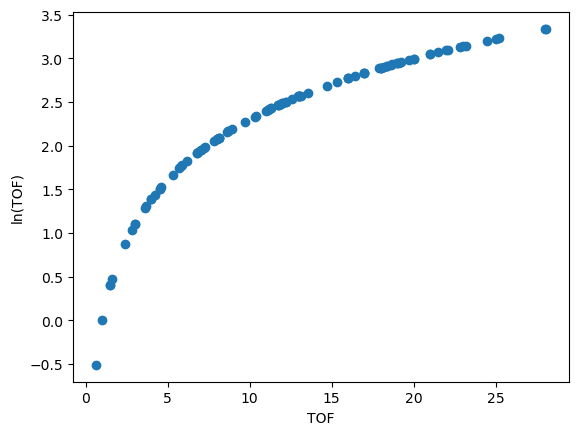

In [18]:
# remove data point for TOF = 0 so that the log can be taken
mask = df0['TOFCO / min−1_Mean'] == 0
df1 = df0[~mask].copy()

df1['ln(TOF)'] = np.log(df1['TOFCO / min−1_Mean'])

# Create scatter plot to show effect of log on target variable
plt.scatter(df1['TOFCO / min−1_Mean'].tolist(), df1['ln(TOF)'].tolist())
plt.xlabel('TOF')
plt.ylabel('ln(TOF)')
plt.show()

In [19]:
df1.describe()

,Cat/_µM,PS_µM,Surf._CMC,Red._mM,Buf_mM,TOFCO / min−1_Mean,ln(TOF)
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,4.559804,96.392157,19.333333,212.843137,454.156863,12.367745,2.299274
std,2.171246,33.703176,9.157947,100.126429,211.456512,6.795293,0.760550
min,1.500000,10.000000,1.000000,1.000000,10.000000,0.600000,-0.510826
25%,2.900000,85.500000,13.000000,169.000000,319.250000,7.000000,1.945910
50%,4.500000,103.500000,20.500000,191.500000,493.500000,11.850000,2.472319
75%,6.200000,115.000000,26.000000,251.000000,590.750000,18.000000,2.890372
max,9.800000,180.000000,38.000000,500.000000,1000.000000,28.100000,3.335770


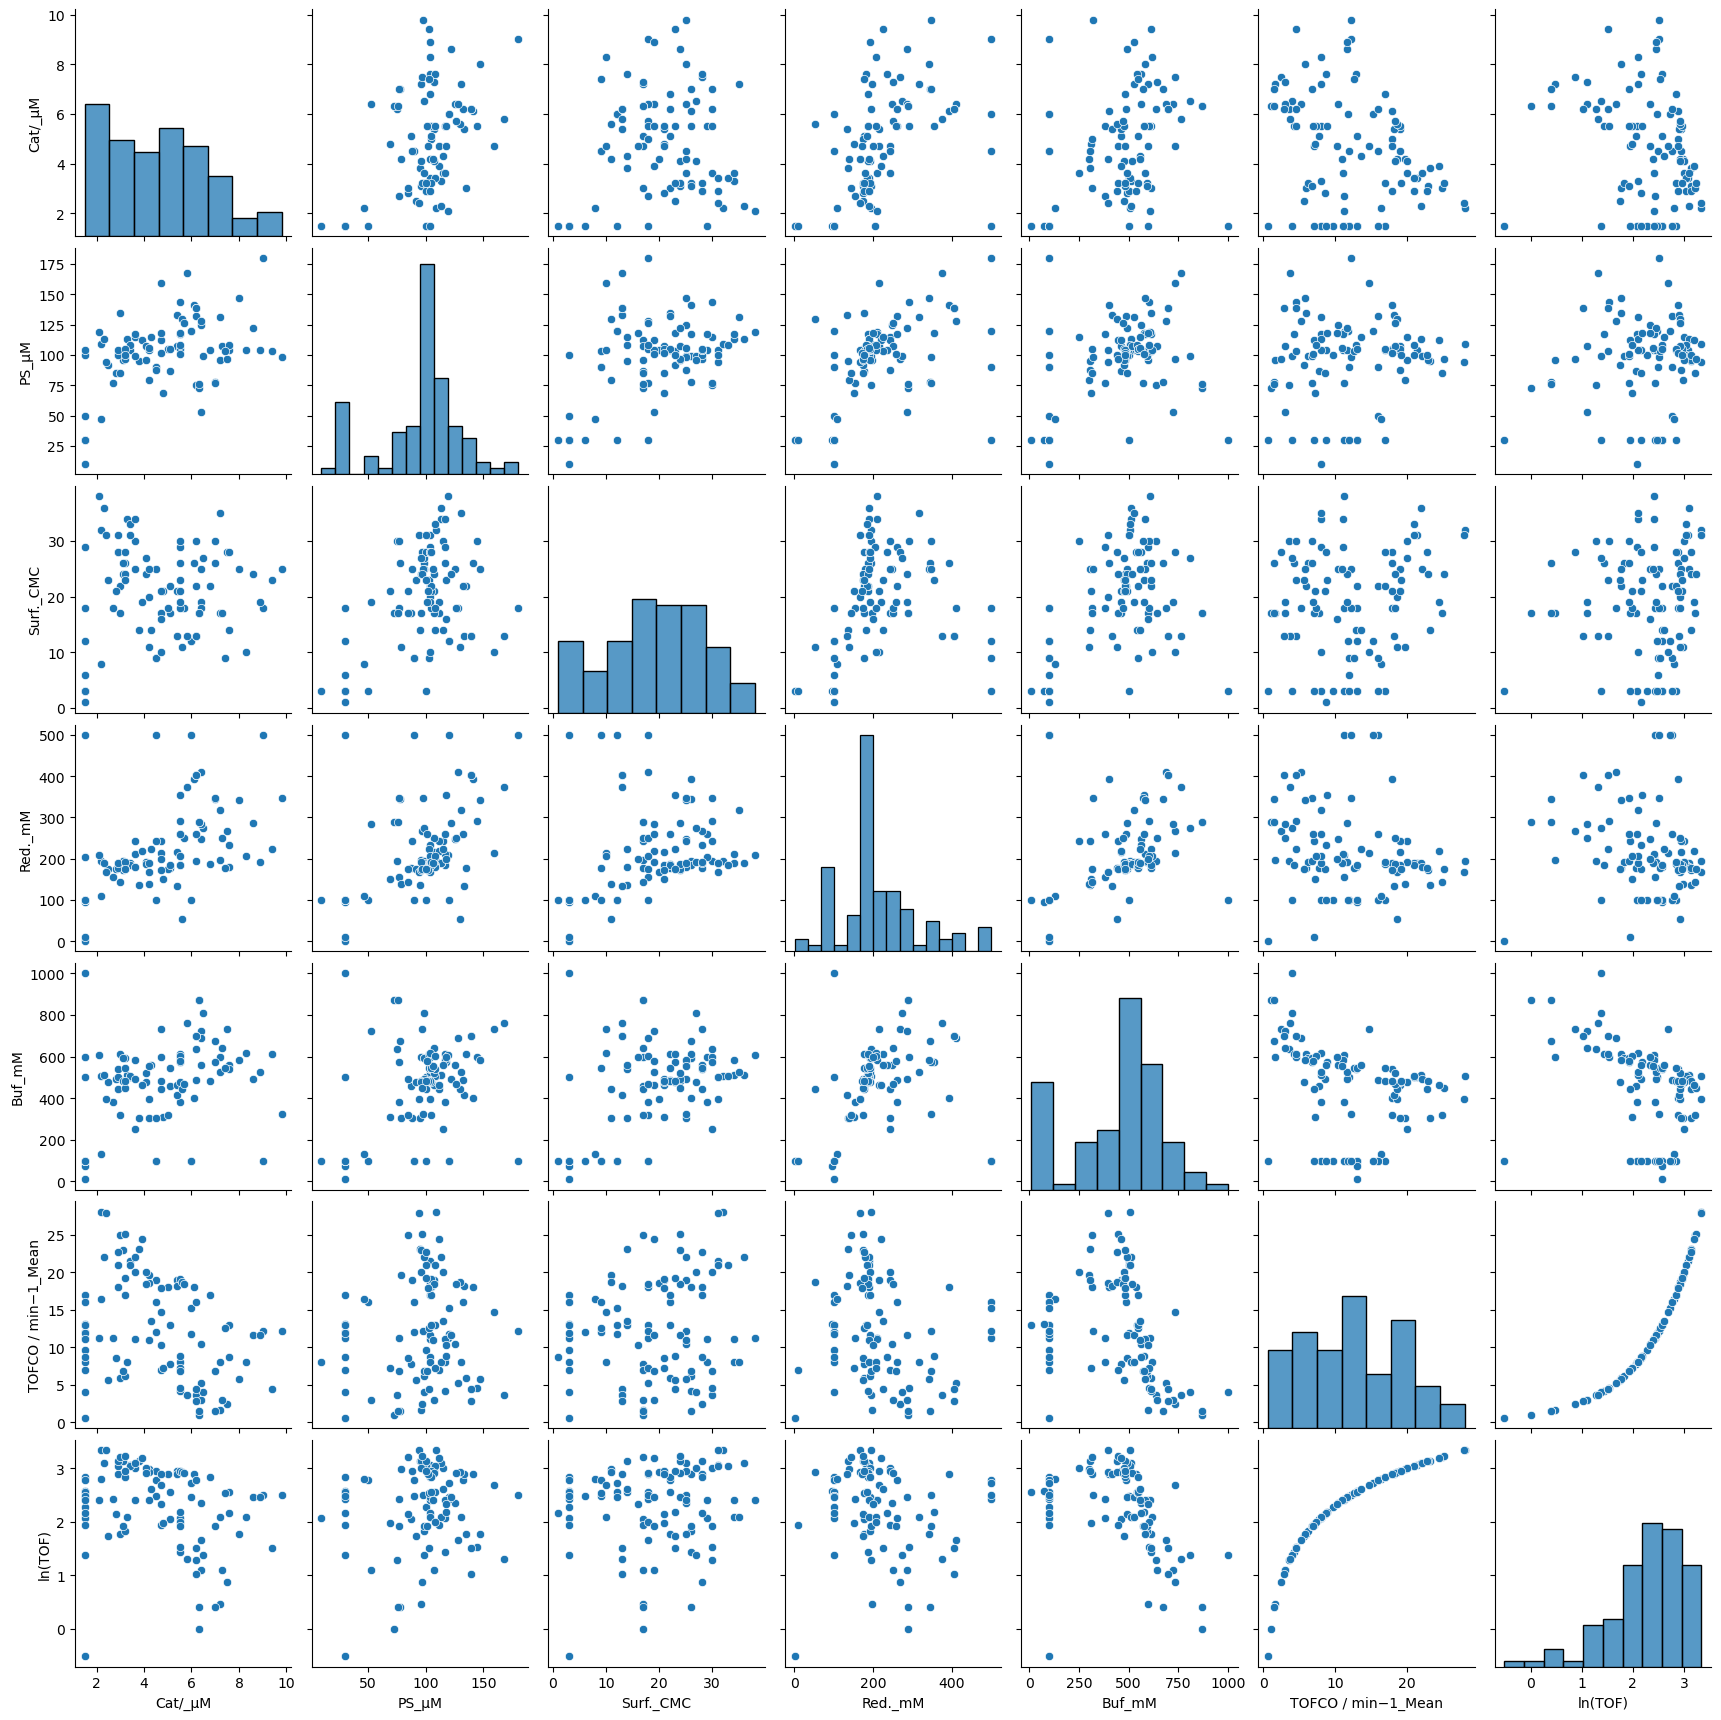

In [20]:
# visualise the data
sns.pairplot(data=df1)

## Modelling the Data

Visualising the data reveals that the variables are not linearly correlated. Need to try a range of different distance- and tree-based regressors to determine the best model for the data.

In [21]:
# create X and y
X = df1.drop(['TOFCO / min−1_Mean', 'ln(TOF)'], axis=1).astype(float)
y = df1['ln(TOF)'].astype(float)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)
print(f'train size: {len(y_train)}, test size: {len(y_test)}')

train size: 71, test size: 31


In [22]:
# Distance based models that need scaling
scaled_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "KNN Regressor": KNeighborsRegressor(),
    "SVR": SVR()
}

# Tree based models
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

print("___Distance based models___")
for name, model in scaled_models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    print(f"{name}:\nTrain R2: {r2_score(y_train, y_train_pred):.2f}\nTest R2: {r2_score(y_test, y_test_pred):.2f}\n")

print("___Tree based models___")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(f"{name}:\nTrain R2: {r2_score(y_train, y_train_pred):.2f}\nTest R2: {r2_score(y_test, y_test_pred):.2f}\n")

___Distance based models___
Linear Regression:
Train R2: 0.49
Test R2: 0.26

Ridge Regression:
Train R2: 0.49
Test R2: 0.25

Lasso Regression:
Train R2: 0.00
Test R2: -0.00

KNN Regressor:
Train R2: 0.60
Test R2: 0.44

SVR:
Train R2: 0.72
Test R2: 0.58

___Tree based models___
Decision Tree:
Train R2: 1.00
Test R2: 0.48

Random Forest:
Train R2: 0.93
Test R2: 0.52

Gradient Boosting:
Train R2: 0.99
Test R2: 0.61



The distance-based models perform poorly compared to the tree-based models, as expected since the variables appear non-linear in the pairplot. The tree-based models perform well, though appear prone to overfitting. The best performing tree-based model, gradient boosting, is investigated further to try to reduce the overfitting. For example, employing stochastic gradient boosting by decreasing the subsample size could help to reduce variance and increase bias.

In [23]:
# gridsearch for hyperparameter tuning
sgb = GradientBoostingRegressor()

hyperparams = {'n_estimators': [100, 200, 500, 1000, 2000],
              'max_features': [1.0, 'sqrt', 'log2'],
              'subsample': [0.1, 0.9, 0.7]}

gridsearch = GridSearchCV(sgb, hyperparams)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 1000, 2000],
                         'subsample': [0.1, 0.9, 0.7]})

In [24]:
print("Best hyperparameters:", gridsearch.best_params_)

Best hyperparameters: {'max_features': 'log2', 'n_estimators': 100, 'subsample': 0.9}


In [25]:
# take best estimator
best_sgb = gridsearch.best_estimator_
sgb_train_score = best_sgb.score(X_train, y_train)
sgb_test_score = best_sgb.score(X_test, y_test)
print(f'Train score: {sgb_train_score:.2f}\nTest score: {sgb_test_score:.2f}')

Train score: 0.99
Test score: 0.61


In [26]:
# save the model
joblib.dump(best_sgb, 'StochasticGradientBoostingRegressor_model.pkl')

['StochasticGradientBoostingRegressor_model.pkl']

While this model still performs well on the training set it is clearly overfitting since this performance cannot be maintained for the unseeen test data. Hyperparameter tuning did not improve the performance of the gradient boosting regressor, even though 'max_features' and 'subsample' of the best estimator are both not default options. This implies that it will be difficult to achieve a better performing model without tuning the other hyperparameters.

SHAP analysis was applied to the stochastic gradient boosting regressor to determine the most important feature and understand how it affects the target variable.

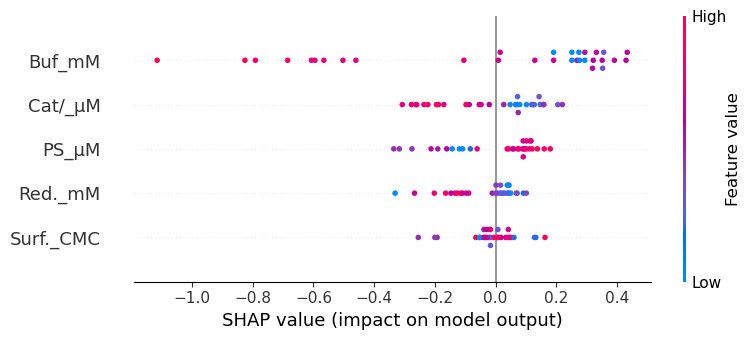

In [27]:
# shap analysis to extract feature importance
# create TreeExplainer
explainer = shap.TreeExplainer(best_sgb)

# calculate shap values
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

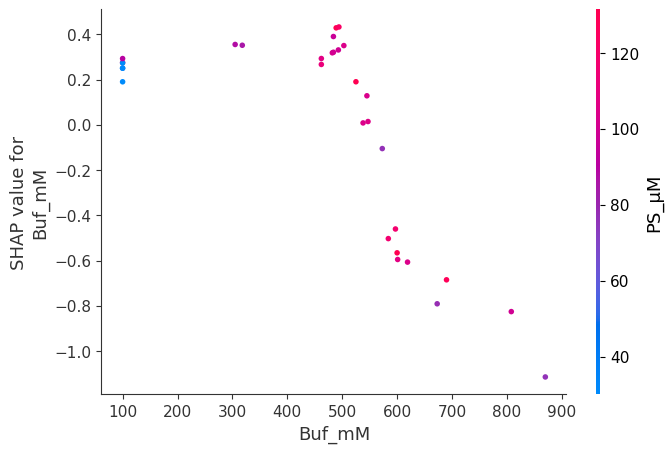

In [28]:
shap.dependence_plot("Buf_mM", shap_values, X_test)

The model predicts the buffer concentration as the most important feature affecting TOF. The SHAP dependence plot shows threshold behaviour, whereby low buffer concentrations increase the TOF until ~600 mM, after which increasing the buffer concentrations negatively impacts the TOF. This reveals why the tree-based models performed much better than the distance-based models, since complex non-linear relationships between the input and target variables are best modelled with tree-based regressors which can split the data at the threshold.

The buffer concentration affecting the performance of the catalytic system can be rationalised by the fact that the buffer concentration directly affects the micelle stability. At high buffer concentrations the micelles will 'salt out' and collaps due to the charges being screened by the buffer. The catalysis will then be hindered because the catalyst and photosensitiser will no longer be in close proximity to each other.

In conclusion, the photocatalytic micelle dataset can be modelled with tree-based stochastic gradient boosting regression which clearly illustrates the threshold behaviour of the buffer concentration on the catalytic system.